In [7]:
# This reads in FITS-format files of the GPI1 filter transmission curves, then fits them
# to spectra of corresponding bands in IFS images to determine approximate spectral resolution.

# The IFS illuminations are simply a broadband source as seen through a particular filter. They
# are not of calibration lamps, which are not available to us---so this procedure finds resolution
# only in this makeshift, approximate way.

# Created 2021 June 29 by E.S.

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
import glob
from scipy.interpolate import UnivariateSpline

%matplotlib qt

In [3]:
stem = "/Users/bandari/Documents/git.repos/gpi2_dst"
#stem = "/Users/bandari/Desktop/dst_data"

stem_ifs_data = "/Users/bandari/Documents/git.repos/gpi2_misc/notebooks_for_development/data/fpr_0620/"

In [4]:
# original GPI1 filters

leaf_H = "/detector_data/GPI-filter-H.fits"
leaf_J = "/detector_data/GPI-filter-J.fits"
leaf_K1 = "/detector_data/GPI-filter-K1.fits"
leaf_K2 = "/detector_data/GPI-filter-K2.fits"
leaf_Y = "/detector_data/GPI-filter-Y.fits"

In [5]:
def single_spec_frame(dir_pass):
    '''
    Reads in all the IFS frames in a directory and returns a median
    '''
    
    file_list = glob.glob(dir_pass + "*fits")
    
    # initialize cube
    cube_arrays = np.zeros((len(file_list),2048,2048))
    
    for file_num in range(0,len(file_list)):
        
        hdul = fits.open(file_list[file_num])        
        cube_arrays[file_num,:,:] = hdul[1].data
        
    # take median
    median_array = np.nanmedian(cube_arrays, axis = 0)
    
    return median_array

In [6]:
# now cut out small spectra in each band

In [7]:
y_median = single_spec_frame(stem_ifs_data + "Y_band/")
y_snippet = y_median[1057:1073,1125:1130]

# take 1D profile
y_band_1d = np.max(y_snippet,axis=1)

In [8]:
j_median = single_spec_frame(stem_ifs_data + "J_band/")
j_snippet = j_median[1046:1068,1125:1130]

# take 1D profile
j_band_1d = np.max(j_snippet,axis=1)

In [9]:
h_median = single_spec_frame(stem_ifs_data + "H_band/")
h_snippet = h_median[1044:1065,1123:1129]

# take 1D profile
h_band_1d = np.max(h_snippet,axis=1)

In [10]:
k1_median = single_spec_frame(stem_ifs_data + "K1_band/")
k1_snippet = k1_median[1038:1049,1113:1120]

# take 1D profile
k1_band_1d = np.max(k1_snippet,axis=1)

In [11]:
# can't see illumination by eye

k2_median = single_spec_frame(stem_ifs_data + "K2_band/")
k2_snippet = k2_median[1046:1065,1125:1130]

In [61]:
# returns arguments around the zeros

num_samples = 1000
def return_half_trans(band_trans_pass):

    x, y = np.arange(len(band_trans_pass)), band_trans_pass
    w = np.isnan(y)
    y[w] = 0.
    spl = UnivariateSpline(x, y, w=~w)
    
    xs = np.linspace(0, len(band_trans_pass), num_samples)
    #plt.plot(xs, spl(xs), 'g', lw=3)
    #plt.plot(x,y)
    #plt.show()
    
    half_trans_y = np.subtract(band_trans_pass,np.max(band_trans_pass))
    
    #print(np.max(band_trans_pass))
    #print(spl(xs))
    #print(np.abs(np.subtract(spl(xs),0.5*np.max(band_trans_pass))))
    idx_list = np.argsort(np.abs(np.subtract(spl(xs),0.5*np.max(band_trans_pass))))[:20]
    
    print("indices of interpolation")
    print(idx_list)
    
    print("height of snippet (pixels)")
    print(len(band_trans_pass))

    return

In [62]:
return_half_trans(y_band_1d)

indices of interpolation
[475 762 474 763 476 761 473 764 760 472 477 765 471 759 478 766 470 758
 479 358]
height of snippet (pixels)
16


In [63]:
return_half_trans(j_band_1d)

indices of interpolation
[509 508 510 507 511 506 512 505 513 504 514 503 502 515 501 516 105 500
 517 499]
height of snippet (pixels)
22


In [64]:
return_half_trans(h_band_1d)

indices of interpolation
[794 795 793  72  73 796 792 797 791 798 790 799  71 789  74 800 788 801
 787 802]
height of snippet (pixels)
21


In [65]:
return_half_trans(k1_band_1d)

indices of interpolation
[596 312 595 313 597 594 311 314 598 593 310 599 315 592 309 600 316 591
 601 308]
height of snippet (pixels)
11


In [66]:
return_half_trans(k2_band_1d)

NameError: name 'k2_band_1d' is not defined

In [55]:
# convert to width in pixel

def indices_2_pixels(arg1_pass,arg2_pass,snippet_height_pixels):
    
    # find filter transmission width, in terms of pixels
    trans_width_pixels = snippet_height_pixels*np.divide(np.subtract(arg2_pass,arg1_pass),num_samples)
    #trans_width_pixels = np.divide(trans_width_finesampling,(num_samples)) # CONVERT HERE
    
    print("Filter width (pixels):")
    print(trans_width_pixels)

In [67]:
# y
print("Y")
indices_2_pixels(475,762,16)
print("----")

Y
Filter width (pixels):
4.592
----


In [68]:
# j
print("J")
indices_2_pixels(105,509,22)
print("----")

J
Filter width (pixels):
8.888
----


In [69]:
# h
print("h")
indices_2_pixels(72,794,21)
print("----")

h
Filter width (pixels):
15.161999999999999
----


In [70]:
# k1
print("k1")
indices_2_pixels(312,596,11)
print("----")

k1
Filter width (pixels):
3.1239999999999997
----


In [95]:
# returns arguments around the zeros

def return_half_filter(wavel_pass, filter_trans_pass):
    
    #print(np.max(band_trans_pass))
    #print(spl(xs))
    #print(np.abs(np.subtract(spl(xs),0.5*np.max(band_trans_pass))))
    idx_list = np.argsort(np.abs(np.subtract(filter_trans_pass,0.5*np.max(filter_trans_pass))))[:10]
    
    print("indices of interpolation")
    print(idx_list)
    
    print("height of filter_trans_pass (pixels)")
    print(len(filter_trans_pass))
    
    print("Wavelength discretion:")
    print(np.median(np.subtract(wavel_pass,np.roll(wavel_pass,1))))

    return

In [96]:
def plot_transmission(file_name_leaf):
    '''
    Reads in FITS file filter transmission and plots it
    
    INPUTS:
    file_name_leaf: leaf of file name beyond the 'stem' set above
    '''
    
    hdul = fits.open(stem + file_name_leaf)
    
    # print some things
    print(hdul.info())
    print(hdul[1].columns)
    
    # convert to table
    evt_data = Table(hdul[1].data, names=["wavel", "transm"])
    
    print((len(np.squeeze(evt_data["wavel"].data))))
    
    # plot
    wavel = np.squeeze(evt_data["wavel"].data)
    transm = np.squeeze(evt_data["transm"].data)
    '''
    plt.plot(wavel,transm)
    plt.show()
    '''
    
    return wavel, transm

In [101]:
# convert to width in wavel

def indices_2_wavel(arg1_pass,arg2_pass,wavel_discret):
    
    # find filter transmission width, in terms of pixels
    trans_width_wavel = wavel_discret*np.subtract(arg2_pass,arg1_pass)
    #trans_width_pixels = np.divide(trans_width_finesampling,(num_samples)) # CONVERT HERE
    
    print("Filter width (wavel):")
    print(trans_width_wavel)

In [105]:
def res_ifs(cent_wavel,del_wavel,del_pixels):
    
    # convert wavelength to pixels; this is delta_lambda
    delta_lambda = np.divide(del_wavel,del_pixels)
    
    print("resolution:")
    print(np.divide(cent_wavel,delta_lambda))

## Y-band

In [102]:
wavel_Y, transm_Y = plot_transmission(leaf_Y)
return_half_filter(wavel_Y, transm_Y)

Filename: /Users/bandari/Documents/git.repos/gpi2_dst/detector_data/GPI-filter-Y.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   ()      
  1                1 BinTableHDU     21   1R x 2C   [2001E, 2001E]   
None
ColDefs(
    name = 'WAVELENGTH'; format = '2001E'
    name = 'TRANSMISSION'; format = '2001E'
)
2001
indices of interpolation
[1189  245  244 1190  246 1191 1188  243  247 1187]
height of filter_trans_pass (pixels)
2001
Wavelength discretion:
0.00020003319


In [103]:
indices_2_wavel(245,1189,0.00020003319)

Filter width (wavel):
0.18883133136


In [106]:
res_ifs(1.0471,0.18883133136,4.592)

resolution:
25.463376047660145


## J-band

In [108]:
wavel_J, transm_J = plot_transmission(leaf_J)
return_half_filter(wavel_J, transm_J)

Filename: /Users/bandari/Documents/git.repos/gpi2_dst/detector_data/GPI-filter-J.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   ()      
  1                1 BinTableHDU     21   1R x 2C   [2501E, 2501E]   
None
ColDefs(
    name = 'WAVELENGTH'; format = '2501E'
    name = 'TRANSMISSION'; format = '2501E'
)
2501
indices of interpolation
[1727  590  591 1726  592  589  593 1728  588  594]
height of filter_trans_pass (pixels)
2501
Wavelength discretion:
0.00020003319


In [110]:
indices_2_wavel(590,1727,0.00020003319)

Filter width (wavel):
0.22743773702999998


In [112]:
res_ifs(cent_wavel=1.2344,del_wavel=0.22743773702999998,del_pixels=8.888)

resolution:
48.238904164583886


## H-band

In [113]:
wavel_H, transm_H = plot_transmission(leaf_H)
return_half_filter(wavel_H, transm_H)

Filename: /Users/bandari/Documents/git.repos/gpi2_dst/detector_data/GPI-filter-H.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   ()      
  1                1 BinTableHDU     21   1R x 2C   [2501E, 2501E]   
None
ColDefs(
    name = 'WAVELENGTH'; format = '2501E'
    name = 'TRANSMISSION'; format = '2501E'
)
2501
indices of interpolation
[ 476 1968 1967 1969 1966 1970  475 1965  474  477]
height of filter_trans_pass (pixels)
2501
Wavelength discretion:
0.00020003319


In [114]:
indices_2_wavel(arg1_pass=476,arg2_pass=1968,wavel_discret=0.00020003319)

Filter width (wavel):
0.29844951948


In [115]:
res_ifs(cent_wavel=1.6472,del_wavel=0.29844951948,del_pixels=15.161999999999999)

resolution:
83.68197892733963


## K1-band

In [116]:
wavel_K1, transm_K1 = plot_transmission(leaf_K1)
return_half_filter(wavel_K1, transm_K1)

Filename: /Users/bandari/Documents/git.repos/gpi2_dst/detector_data/GPI-filter-K1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   ()      
  1                1 BinTableHDU     21   1R x 2C   [3501E, 3501E]   
None
ColDefs(
    name = 'WAVELENGTH'; format = '3501E'
    name = 'TRANSMISSION'; format = '3501E'
)
3501
indices of interpolation
[ 997 2431  996  998 2430  995 2432  999 2429 1000]
height of filter_trans_pass (pixels)
3501
Wavelength discretion:
0.00020003319


In [117]:
indices_2_wavel(arg1_pass=997,arg2_pass=2431,wavel_discret=0.00020003319)

Filter width (wavel):
0.28684759445999997


In [118]:
res_ifs(cent_wavel=2.0424,del_wavel=0.28684759445999997,del_pixels=3.1239999999999997)

resolution:
22.243371474010164


In [ ]:
############

In [81]:
wavel_J, transm_J = plot_transmission(leaf_J)

Filename: /Users/bandari/Documents/git.repos/gpi2_dst/detector_data/GPI-filter-J.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   ()      
  1                1 BinTableHDU     21   1R x 2C   [2501E, 2501E]   
None
ColDefs(
    name = 'WAVELENGTH'; format = '2501E'
    name = 'TRANSMISSION'; format = '2501E'
)
2501


In [82]:
wavel_J, transm_J = plot_transmission(leaf_H)

Filename: /Users/bandari/Documents/git.repos/gpi2_dst/detector_data/GPI-filter-H.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   ()      
  1                1 BinTableHDU     21   1R x 2C   [2501E, 2501E]   
None
ColDefs(
    name = 'WAVELENGTH'; format = '2501E'
    name = 'TRANSMISSION'; format = '2501E'
)
2501


In [83]:
wavel_J, transm_J = plot_transmission(leaf_K1)

Filename: /Users/bandari/Documents/git.repos/gpi2_dst/detector_data/GPI-filter-K1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   ()      
  1                1 BinTableHDU     21   1R x 2C   [3501E, 3501E]   
None
ColDefs(
    name = 'WAVELENGTH'; format = '3501E'
    name = 'TRANSMISSION'; format = '3501E'
)
3501


In [84]:
wavel_J, transm_J = plot_transmission(leaf_K2)

Filename: /Users/bandari/Documents/git.repos/gpi2_dst/detector_data/GPI-filter-K2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   ()      
  1                1 BinTableHDU     21   1R x 2C   [3501E, 3501E]   
None
ColDefs(
    name = 'WAVELENGTH'; format = '3501E'
    name = 'TRANSMISSION'; format = '3501E'
)
3501


In [67]:
h_median = single_spec_frame(stem_ifs_data + "H_band/")
#j_snippet = j_median[1046:1065,1125:1130]

In [ ]:
from scipy.interpolate import interp1d
f = interp1d( y, x )
f(0.5)

In [68]:
plt.imshow(h_median)
plt.show()

In [66]:
plt.imshow(h_snippet)
plt.show()

In [60]:
plt.imshow(test)
plt.show()

In [47]:
file_list = glob.glob(J_band/*fits")

In [48]:
file_list

['/Users/bandari/Documents/git.repos/gpi2_misc/notebooks_for_development/data/fpr_0620/J_band/S20210427E0026.fits',
 '/Users/bandari/Documents/git.repos/gpi2_misc/notebooks_for_development/data/fpr_0620/J_band/S20210427E0027.fits',
 '/Users/bandari/Documents/git.repos/gpi2_misc/notebooks_for_development/data/fpr_0620/J_band/S20210427E0020.fits',
 '/Users/bandari/Documents/git.repos/gpi2_misc/notebooks_for_development/data/fpr_0620/J_band/S20210427E0017.fits',
 '/Users/bandari/Documents/git.repos/gpi2_misc/notebooks_for_development/data/fpr_0620/J_band/S20210427E0021.fits',
 '/Users/bandari/Documents/git.repos/gpi2_misc/notebooks_for_development/data/fpr_0620/J_band/S20210427E0022.fits',
 '/Users/bandari/Documents/git.repos/gpi2_misc/notebooks_for_development/data/fpr_0620/J_band/S20210427E0018.fits',
 '/Users/bandari/Documents/git.repos/gpi2_misc/notebooks_for_development/data/fpr_0620/J_band/S20210427E0019.fits',
 '/Users/bandari/Documents/git.repos/gpi2_misc/notebooks_for_development

In [32]:
plt.imshow(test)
plt.show()

In [11]:
def info_standalone(file_name_leaf):
    '''
    Reads in a FITS file and prints the HDU primary and extensions
    
    INPUTS:
    file_name_leaf: leaf of file name beyond the 'stem' set above
    '''
    
    hdul = fits.open(stem + file_name_leaf)
    
    # print some things
    print(hdul.info())

In [13]:
hdul = fits.open(stem + "/empirical_dst_data/S20200201S0247.fits")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/bandari/Documents/git.repos/gpi2_dst/empirical_dst_data/S20200201S0247.fits'

Filename: /Users/bandari/Documents/git.repos/gpi2_dst/detector_data/GPI-filter-K1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   ()      
  1                1 BinTableHDU     21   1R x 2C   [3501E, 3501E]   
None
ColDefs(
    name = 'WAVELENGTH'; format = '3501E'
    name = 'TRANSMISSION'; format = '3501E'
)


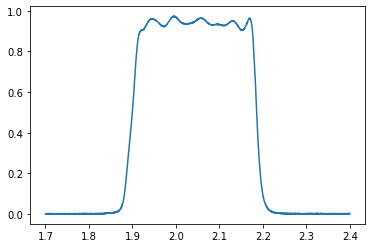

In [8]:
wavel_K1, transm_K1 = plot_transmission(leaf_K1)

Filename: /Users/bandari/Documents/git.repos/gpi2_dst/detector_data/GPI-filter-K2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   ()      
  1                1 BinTableHDU     21   1R x 2C   [3501E, 3501E]   
None
ColDefs(
    name = 'WAVELENGTH'; format = '3501E'
    name = 'TRANSMISSION'; format = '3501E'
)


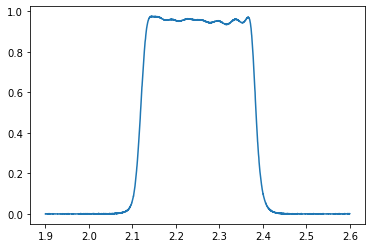

In [9]:
wavel_K2, transm_K2 = plot_transmission(leaf_K2)

Filename: /Users/bandari/Documents/git.repos/gpi2_dst/detector_data/GPI-filter-Y.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   ()      
  1                1 BinTableHDU     21   1R x 2C   [2001E, 2001E]   
None
ColDefs(
    name = 'WAVELENGTH'; format = '2001E'
    name = 'TRANSMISSION'; format = '2001E'
)


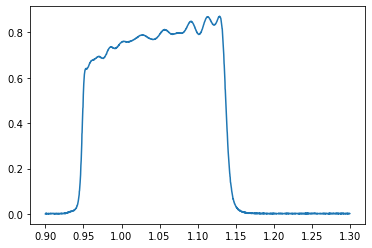

In [10]:
wavel_Y, transm_Y = plot_transmission(leaf_Y)

In [14]:
hdul = fits.open(stem + test)

# print some things
print(hdul.info())
print(hdul[1].columns)

Filename: /Users/bandari/Documents/git.repos/gpi2_dst/Microlens/ifu_microlens_psfY.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      12   (55, 55, 925)   float64   
None


IndexError: list index out of range

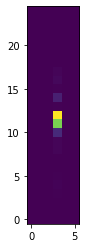

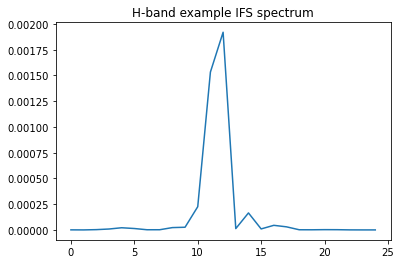

In [29]:
# plot low-res spectra from simulated frames

hdul = fits.open(stem + "/zem/test_H.fits")

img = hdul[0].data[490:515,504:510]

plt.imshow(img, origin="lower")
plt.show()

plt.clf()
plt.plot(np.max(img,axis=1))
plt.title("H-band example IFS spectrum (simulated)")
plt.show()

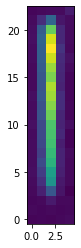

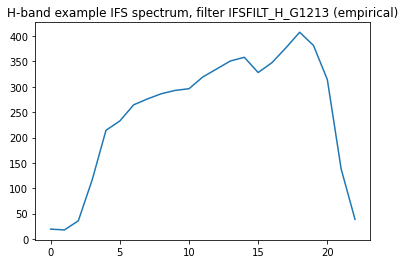

In [37]:
# plot low-res spectra from simulated frames

hdul = fits.open("/Users/bandari/Desktop/gpi_dst_relevant_data/spectral_empirical_data/S20131210S0025.fits")

img = hdul[1].data[989:1012,975:980]

plt.imshow(img, origin="lower")
plt.show()

plt.clf()
plt.plot(np.max(img,axis=1))
plt.title("H-band example IFS spectrum, filter IFSFILT_H_G1213 (empirical)")
plt.show()

array([[-2.1762674 , -1.0364825 , -0.6754992 , ..., -8.127111  ,
        -1.5940858 , -4.9919353 ],
       [-3.6632104 ,  1.2999232 , -1.0994625 , ...,  1.3982334 ,
        -2.9811826 , -0.15629798],
       [-2.1255763 , -0.5357142 , -1.2914746 , ..., -2.0026882 ,
        -3.0518432 , -2.266897  ],
       ...,
       [ 0.27380952,  3.393625  ,  1.1739631 , ...,  4.356759  ,
        -0.02265746,  1.1109833 ],
       [ 0.36751145, -1.8982335 ,  3.6363287 , ...,  3.5195854 ,
         0.685484  , -1.4973117 ],
       [ 5.56106   ,  2.87596   , -0.26075283, ..., -2.008833  ,
         3.2108295 ,  1.9635177 ]], dtype=float32)